In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import jax.numpy as jnp
import jax.random as jr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from dynamax.hidden_markov_model import LogisticRegressionHMM

In [2]:
raw_df = pd.read_csv('/Users/yang/Documents/Wilbrecht_Lab/data/processed_tracks/merged_df.csv')
behavior_df = raw_df[['animal', 'session', 'trial', 'offer_prob', 'restaurant', 'reward', 'sleap_decision', 'bonsai_decision']]
behavior_df = behavior_df.drop_duplicates(subset=['animal', 'session', 'trial'])

sns.set_theme(font="Arial", context='talk', style='white', color_codes=False)

/var/folders/81/kqx_5t9n5vz_mq7d7n66fmdr0000gn/T/ipykernel_51114/454870021.py:1: DtypeWarning: Columns (230,238,239,246) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('/Users/yang/Documents/Wilbrecht_Lab/data/processed_tracks/merged_df.csv')


# Decision Stats

In [3]:
behavior_df['bonsai_decision'].fillna('quit', inplace=True)
behavior_df.loc[(behavior_df['sleap_decision'] == 'quit') & (behavior_df['bonsai_decision'] == 'reject'), 'sleap_decision'] = 'error_quit'
diff_df = behavior_df[behavior_df['sleap_decision'] != behavior_df['bonsai_decision']]
diff_df[['sleap_decision', 'bonsai_decision']].value_counts()

sleap_decision  bonsai_decision
reject          quit               1894
error_quit      reject              141
reject          accept                8
accept          quit                  4
dtype: int64

# Decision State Analysis

In [4]:
# prepar the dataframe structure for calculating rolling accept rate for both low and high offers
behavior_df['low_offer'] = behavior_df['offer_prob'].apply(lambda x: 1 if x in [0, 20] else 0)
behavior_df['high_offer'] = behavior_df['offer_prob'].apply(lambda x: 1 if x in [80, 100] else 0)
behavior_df['accept'] = behavior_df['sleap_decision'].apply(lambda x: 1 if x in ['accept', 'quit', 'error_quit'] else 0)

behavior_df['low_accept'] = np.where(behavior_df['low_offer'] == 1, behavior_df['accept'], np.nan)
behavior_df['high_accept'] = np.where(behavior_df['high_offer'] == 1, behavior_df['accept'], np.nan)
behavior_df['low_reward'] = np.where(behavior_df['low_accept'] == 1, behavior_df['reward'], np.nan)
behavior_df['high_reward'] = np.where(behavior_df['high_accept'] == 1, behavior_df['reward'], np.nan)

In [5]:
behavior_df['animal'].unique()

array(['RRM026', 'RRM027', 'RRM028', 'RRM029', 'RRM030', 'RRM031',
       'RRM032', 'RRM033', 'RRM035', 'RRM036'], dtype=object)

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


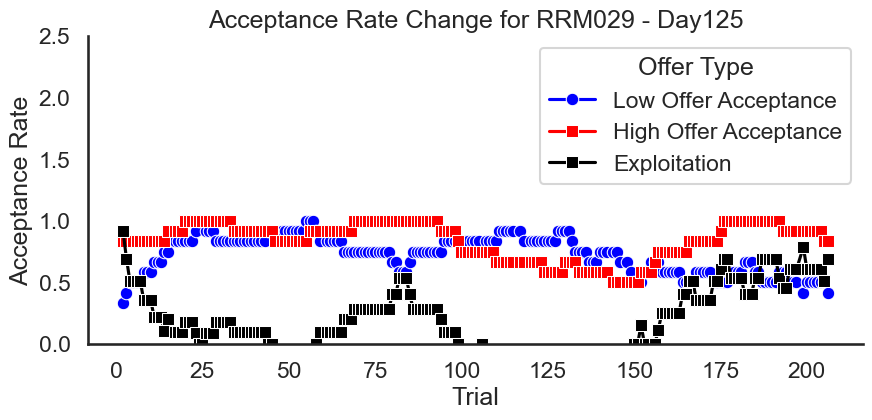

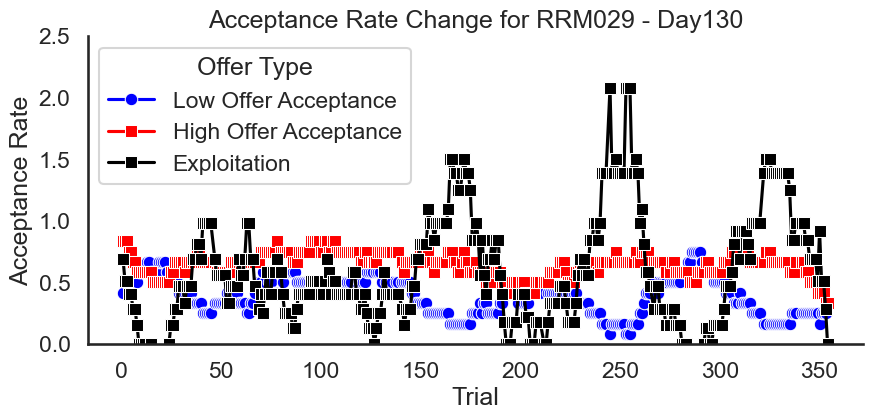

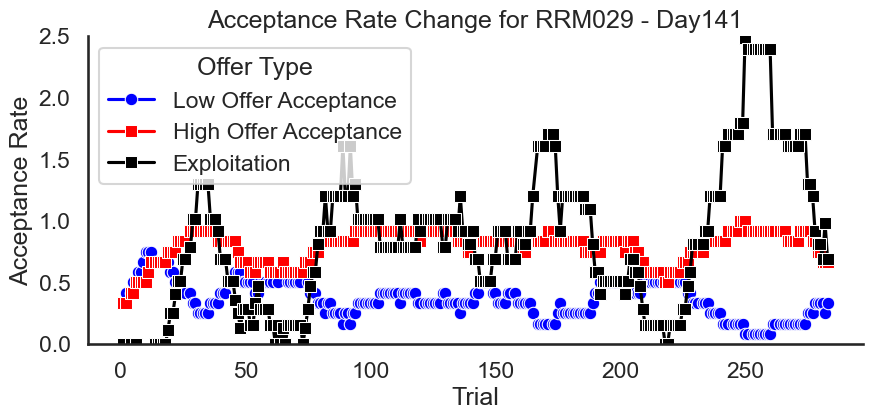

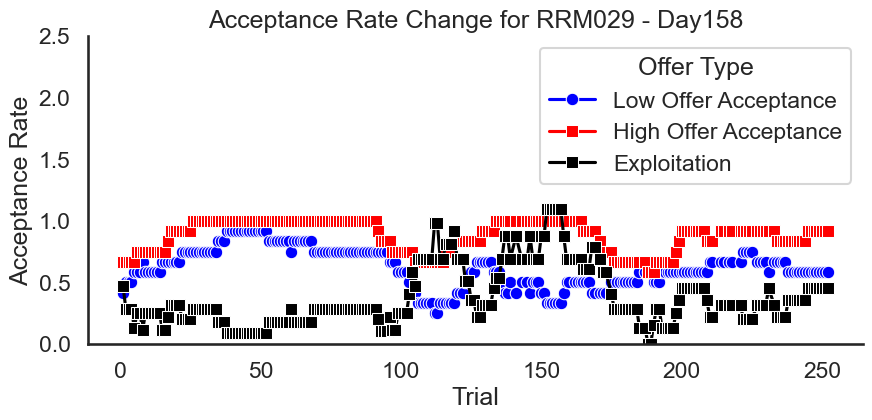

In [18]:
# Define a function to calculate rolling accept rate with a sliding train logic
window_size = 12 
animal_id = 'RRM029'

def calculate_sliding_rate(accept_column, window_size=3):
    # calculate sliding accept/reward rate and skip NaN
    train = []
    accept_rate_list = []

    # Iterate through each entry in the accept column
    for val in accept_column:
        if not np.isnan(val):  # If the value is not NaN, update the train
            train.append(val)
            if len(train) > window_size:
                train.pop(0)  # Remove the oldest value to maintain window size
            # Calculate the average acceptance rate using the current train
            accept_rate_list.append(np.mean(train))
        else:
            # If NaN, use the most recent train to calculate the average acceptance rate
            if train:
                accept_rate_list.append(np.mean(train))  # Use the existing train's average
            else:
                accept_rate_list.append(np.nan)  # If train is empty, keep as NaN
    
    return accept_rate_list

behavior_df['low_accept_rate'] = calculate_sliding_rate(behavior_df['low_accept'], window_size)
behavior_df['high_accept_rate'] = calculate_sliding_rate(behavior_df['high_accept'], window_size)
behavior_df['low_reward_rate'] = calculate_sliding_rate(behavior_df['low_reward'], window_size)
behavior_df['high_reward_rate'] = calculate_sliding_rate(behavior_df['high_reward'], window_size)
behavior_df['exploitation'] = - np.log(behavior_df['low_accept_rate'] / behavior_df['high_accept_rate'])

animal_df = behavior_df[behavior_df['animal'] == animal_id]
unique_sessions = animal_df['session'].unique()

for session in unique_sessions:
    filtered_session_df = animal_df[animal_df['session'] == session].copy()
    plt.figure(figsize=(10, 4))

    sns.lineplot(
        data=filtered_session_df,
        x='trial',
        y='low_accept_rate',
        markers=True,
        dashes=False,
        marker='o',
        color='blue',
        label='Low Offer Acceptance'
    )

    sns.lineplot(
        data=filtered_session_df,
        x='trial',
        y='high_accept_rate',
        markers=True,
        dashes=False,
        marker='s',
        color='red',
        label='High Offer Acceptance'
    )
    
    sns.lineplot(
        data=filtered_session_df,
        x='trial',
        y='exploitation',
        markers=True,
        dashes=False,
        marker='s',
        color='black',
        label='Exploitation'
    )
    sns.despine()
    plt.title(f'Acceptance Rate Change for {animal_id} - {session}')
    plt.xlabel('Trial')
    plt.ylabel('Acceptance Rate')
    plt.ylim(0, 2.5)
    plt.legend(title='Offer Type')
    plt.show()

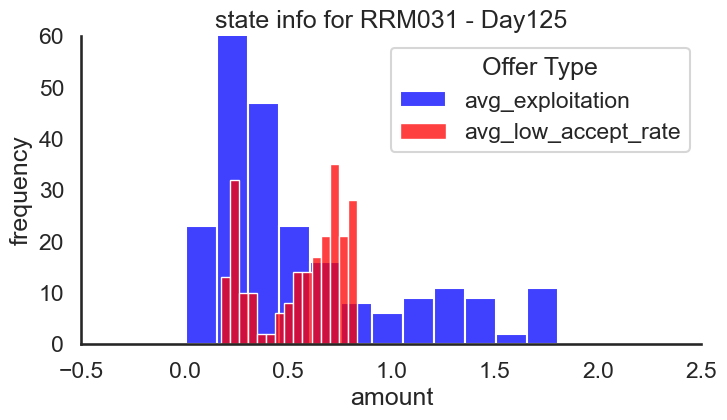

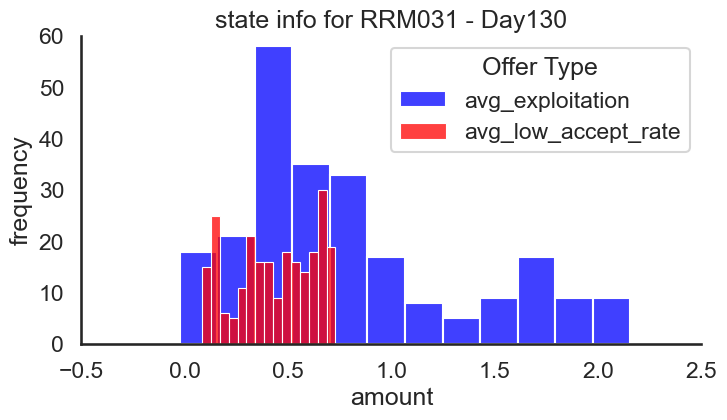

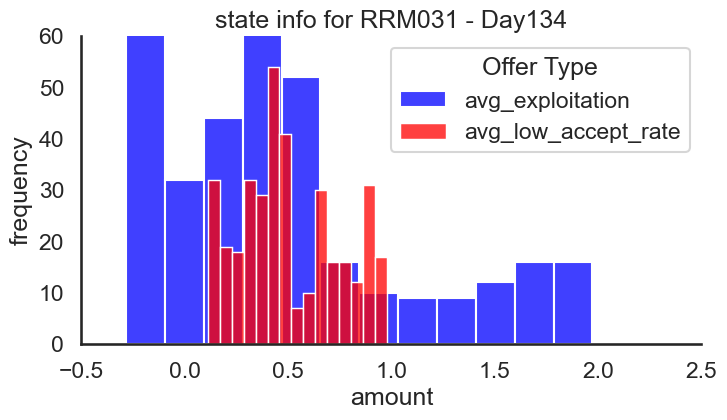

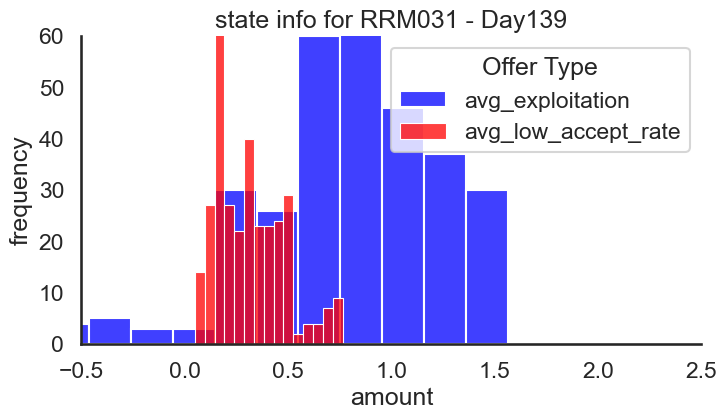

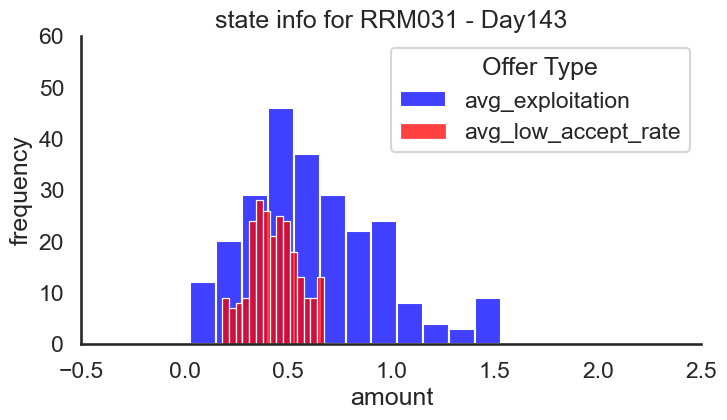

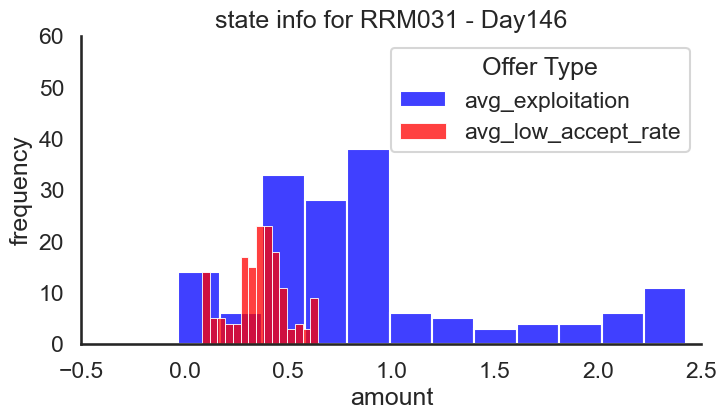

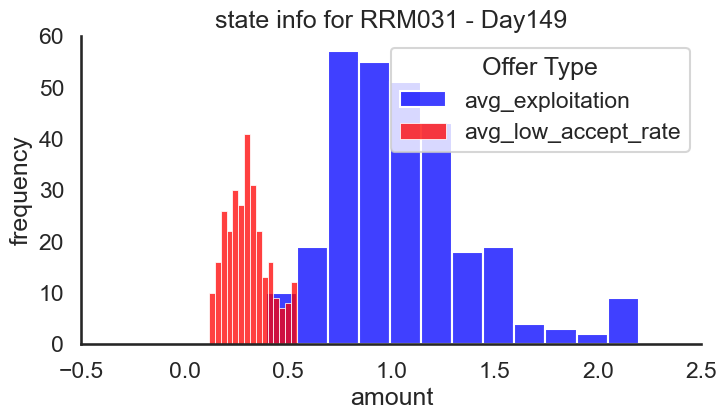

In [7]:
# pick the animal with the most stable states
data_df = pd.DataFrame({
    'animal': behavior_df['animal'],
    'session': behavior_df['session'],
    'trial': behavior_df['trial'],
    'choice': behavior_df['accept'],
    'reward': behavior_df['reward'],
    'offer_prob': behavior_df['offer_prob'],
    'low_reward_rate': behavior_df['low_reward_rate'],
    'high_reward_rate': behavior_df['high_reward_rate'],
})
data_df['accum_reward_count'] = behavior_df.groupby('session')['reward'].cumsum()

time_window = 12
# calculate the mean of the potential decision-related variables within the time window
# avg_low_reward_rate and avg_high_reward_rate are about the updateing prior to the offer
# avg_exploitation and avg_low_accept_rate is the indicating previous decision preference (respectively, exploitation and general engagement)
data_df['avg_low_reward_rate'] = data_df['low_reward_rate'].rolling(window=time_window, min_periods=1).mean()
data_df['avg_high_reward_rate'] = data_df['high_reward_rate'].rolling(window=time_window, min_periods=1).mean()
data_df['avg_exploitation'] = behavior_df['exploitation'].rolling(window=time_window, min_periods=1).mean()
data_df['avg_low_accept_rate'] = behavior_df['low_accept_rate'].rolling(window=time_window, min_periods=1).mean()

selected_columns = [
    'offer_prob',                   # Current contex
    'accum_reward_count',           # Total accumulated reward in this trial
    'avg_low_reward_rate',          # average Rew% in low offers over 12 trials
    'avg_high_reward_rate',         # average Rew% in high offers over 12 trials
    'avg_exploitation',             # -log(low/high) over 12 trials
    'avg_low_accept_rate'           # log(low) over 12 trials
]

data_df.dropna(inplace=True)

animal_df = data_df[data_df['animal'] == animal_id]
unique_sessions = animal_df['session'].unique()

for session in unique_sessions:
    session_df = animal_df[animal_df['session'] == session].copy()
    plt.figure(figsize=(8, 4))

    sns.histplot(
        data=session_df,
        x='avg_exploitation',
        bins=12,
        color='blue',
        label='avg_exploitation'
    )
    sns.histplot(
        data=session_df,
        x='avg_low_accept_rate',
        bins=15,
        color='red',
        label='avg_low_accept_rate'
    )
    
    sns.despine()
    plt.title(f'state info for {animal_id} - {session}')
    plt.xlabel('amount')
    plt.ylabel('frequency')
    plt.legend(title='Offer Type')
    plt.xlim(-0.5, 2.5)
    plt.ylim(0, 60)
    plt.show()

In [8]:
# pick animal with lowert variance in single session and lowest KL diverngence across-sessions
from scipy.stats import entropy

lengths = []


animal_df = data_df[data_df['animal'] == animal_id]
unique_sessions = animal_df['session'].unique()

# Iterate over all pairs of sessions
for i, session_1 in enumerate(unique_sessions):
    dist_1 = animal_df[animal_df['session'] == session_1]['avg_exploitation']
    # Create a histogram with a fixed number of bins
    lengths.append(len(dist_1))
        
bins_df = pd.DataFrame({'length': lengths})
bins_df['square'] = bins_df['length'].apply(np.sqrt)
bins_df['sturges'] = bins_df['length'].apply(lambda x: int(np.log2(x) + 1))
bins_df['rice'] = bins_df['length'].apply(lambda x: int(2*x**(1/3)))

bins_df.describe()


,length,square,sturges,rice
count,7.000000,7.000000,7.000000,7.000000
mean,265.142857,16.161250,8.428571,12.285714
std,68.501651,2.148562,0.534522,1.253566
min,158.000000,12.569805,8.000000,10.000000
25%,236.000000,15.361981,8.000000,12.000000
50%,243.000000,15.588457,8.000000,12.000000
75%,309.500000,17.583872,9.000000,13.000000
max,364.000000,19.078784,9.000000,14.000000


In [9]:
# pick animal with lowert variance in single session and lowest KL diverngence across-sessions
from scipy.stats import entropy

variance_df = data_df.groupby(['animal', 'session'])['avg_exploitation'].var().reset_index()

def average_kl_divergence(p, q):
    """Calculate KL divergence between two distributions p and q."""
    ave_kl = (entropy(p, q) + entropy(q, p)) / 2
    return ave_kl

def calculate_mutual_kl(data_df, animal_id, num_bins=12):
    """Calculate average pairwise KL divergence for an animal across sessions with uniform binning."""
    animal_df = data_df[data_df['animal'] == animal_id]
    unique_sessions = animal_df['session'].unique()
    
    kl_matrix = []

    for i, session_1 in enumerate(unique_sessions):
        dist_1 = animal_df[animal_df['session'] == session_1]['avg_exploitation']

        hist_1, bin_edges = np.histogram(dist_1, bins=num_bins, density=True)

        for j, session_2 in enumerate(unique_sessions):
            if i < j:
                dist_2 = animal_df[animal_df['session'] == session_2]['avg_exploitation']

                hist_2, _ = np.histogram(dist_2, bins=bin_edges, density=True)
                
                hist_1 += 1e-10
                hist_2 += 1e-10

                # Normalize histograms to form probability distributions
                hist_1 /= np.sum(hist_1)
                hist_2 /= np.sum(hist_2)
                
                # Compute KL divergence between the histograms
                kl_value = average_kl_divergence(hist_1, hist_2)
                kl_matrix.append(kl_value)
    
    average_kl = np.mean(kl_matrix)
    
    return average_kl

avg_kl_divergence = calculate_mutual_kl(data_df, animal_id)

mutual_kl = []

for animal_id in data_df['animal'].unique():
    avg_kl_divergence = calculate_mutual_kl(data_df, animal_id)
        
    variance_df.loc[variance_df['animal'] == animal_id, 'avg_kl_divergence'] = avg_kl_divergence

variance_df[variance_df['animal'].isin(['RRM028', 'RRM031', 'RRM032', 'RRM033'])]

,animal,session,avg_exploitation,avg_kl_divergence
7,RRM028,Day123,0.239011,1.689077
8,RRM028,Day130,0.327135,1.689077
9,RRM028,Day136,0.124124,1.689077
10,RRM028,Day141,0.296047,1.689077
11,RRM028,Day151,0.243148,1.689077
12,RRM028,Day156,0.231202,1.689077
23,RRM031,Day125,0.208816,1.830153
24,RRM031,Day130,0.304577,1.830153
25,RRM031,Day134,0.346474,1.830153
26,RRM031,Day139,0.249567,1.830153


In [10]:
# data preparation
data_df = pd.DataFrame({
    'animal': behavior_df['animal'],
    'session': behavior_df['session'],
    'trial': behavior_df['trial'],
    'choice': behavior_df['accept'],
    'reward': behavior_df['reward'],
    'offer_prob': behavior_df['offer_prob'],
    'low_reward_rate': behavior_df['low_reward_rate'],
    'high_reward_rate': behavior_df['high_reward_rate'],
})
data_df['accum_reward_count'] = behavior_df.groupby('session')['reward'].cumsum()

time_window = 12
# calculate the mean of the potential decision-related variables within the time window
# avg_low_reward_rate and avg_high_reward_rate are about the updateing prior to the offer
# avg_exploitation and avg_low_accept_rate is the indicating previous decision preference (respectively, exploitation and general engagement)
data_df['avg_low_reward_rate'] = data_df['low_reward_rate'].rolling(window=time_window, min_periods=1).mean()
data_df['avg_high_reward_rate'] = data_df['high_reward_rate'].rolling(window=time_window, min_periods=1).mean()
data_df['avg_exploitation'] = behavior_df['exploitation'].rolling(window=time_window, min_periods=1).mean()
data_df['avg_low_accept_rate'] = behavior_df['low_accept_rate'].rolling(window=time_window, min_periods=1).mean()

selected_columns = [
    'offer_prob',                   # Current contex
    'accum_reward_count',           # Total accumulated reward in this trial
    'avg_low_reward_rate',          # average Rew% in low offers over 12 trials
    'avg_high_reward_rate',         # average Rew% in high offers over 12 trials
    'avg_exploitation',             # -log(low/high) over 12 trials
    'avg_low_accept_rate'           # log(low) over 12 trials
]

data_df.dropna(inplace=True)

X = data_df[selected_columns].values
y = data_df['choice'].values

data_df.head()

,animal,session,trial,choice,reward,offer_prob,low_reward_rate,high_reward_rate,accum_reward_count,avg_low_reward_rate,avg_high_reward_rate,avg_exploitation,avg_low_accept_rate
3,RRM026,Day151,4,1,1,80.0,0.333333,1.000000,2,0.291667,1.000000,-0.0,1.0
4,RRM026,Day151,5,1,0,20.0,0.250000,1.000000,2,0.283333,1.000000,-0.0,1.0
5,RRM026,Day151,6,1,1,80.0,0.250000,1.000000,3,0.277778,1.000000,-0.0,1.0
6,RRM026,Day151,7,1,0,80.0,0.250000,0.666667,3,0.273810,0.916667,-0.0,1.0
7,RRM026,Day151,8,1,1,80.0,0.250000,0.750000,4,0.270833,0.883333,-0.0,1.0


In [11]:
# which animal to model
unique_combinations = data_df[['animal', 'session']].drop_duplicates().groupby('animal').size()
combinations = data_df[['animal', 'session']].groupby(['animal','session']).size()
animals_to_model = ['RRM028', 'RRM031', 'RRM032', 'RRM033']
print(unique_combinations)
print(combinations)
print('animals to model: 28, 31, 32, 33')

animal
RRM026    4
RRM027    3
RRM028    6
RRM029    4
RRM030    6
RRM031    7
RRM032    8
RRM033    7
RRM035    2
RRM036    4
dtype: int64
animal  session
RRM026  Day151      61
        Day160     191
        Day167     195
        Day172     125
RRM027  Day155     288
        Day170     219
        Day175     242
RRM028  Day123     284
        Day130     350
        Day136     401
        Day141     381
        Day151     209
        Day156     214
RRM029  Day125     197
        Day130     340
        Day141     272
        Day158     238
RRM030  Day139     166
        Day143      78
        Day146     159
        Day149     247
        Day154     125
        Day159     266
RRM031  Day125     233
        Day130     239
        Day134     364
        Day139     329
        Day143     243
        Day146     158
        Day149     290
RRM032  Day118     202
        Day122     259
        Day128     185
        Day132     127
        Day135     203
        Day138     355
        Day143  

In [12]:
num_states = 3
transition_matrix_stickiness = 5.0

key = jr.PRNGKey(3)
k1, k2, k3 = jr.split(key, 3)
input_dim = X.shape[1]

ll_results = []
for animal_id in animals_to_model:
    animal_df = data_df[data_df['animal'] == animal_id]
    
    # logistic regerssion
    X = animal_df[selected_columns].values
    y = animal_df['choice'].values
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lr = LogisticRegression(class_weight='balanced')
    lr.fit(X_scaled, y)

    initial_weights = lr.coef_
    initial_biases = lr.intercept_

    for test_session in animal_df['session'].unique():
        test_mask = (animal_df['session'] == test_session)
        train_mask = ~test_mask

        X_train, y_train = X_scaled[train_mask], y[train_mask]
        X_test, y_test = X_scaled[test_mask], y[test_mask]

        hmm = LogisticRegressionHMM(num_states=num_states, input_dim=input_dim, transition_matrix_stickiness=transition_matrix_stickiness)
        weights = initial_weights + 0.01 * jr.normal(k2, shape=(num_states, input_dim))
        biases = initial_biases + 0.01 * jr.normal(k3, shape=(num_states,))
        params, props = hmm.initialize(key=k1, emission_weights=weights, emission_biases=biases)
        params, lps = hmm.fit_em(params, props, y_train, inputs=X_train, num_iters=100)

        marginal_ll_test = hmm.marginal_log_prob(params, y_test, inputs=X_test)
        avg_log_likelihood = marginal_ll_test / len(y_test)
        ll_results.append({'animal': animal_id, 'session': test_session, 'likelihood': avg_log_likelihood})

ll_results_df = pd.DataFrame(ll_results)

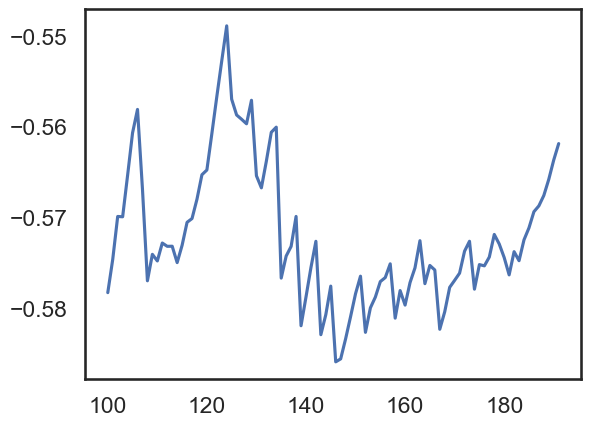

In [13]:
lls = []
ks = []
for k in range(100, len(y_test)):
    marginal_ll_test = hmm.marginal_log_prob(params, y_test[:k], inputs=X_test[:k])
    avg_log_likelihood = marginal_ll_test / k
    lls.append(avg_log_likelihood)
    ks.append(k)
plt.plot(ks, lls)

In [14]:
ll_results_df

,animal,session,likelihood
0,RRM028,Day123,-0.6132827
1,RRM028,Day130,-0.62526906
2,RRM028,Day136,-0.5750232
3,RRM028,Day141,-0.5697591
4,RRM028,Day151,-0.5806441
5,RRM028,Day156,-0.54449767
6,RRM031,Day125,-0.48499146
7,RRM031,Day130,-0.65494084
8,RRM031,Day134,-0.6255665
9,RRM031,Day139,-0.6057176


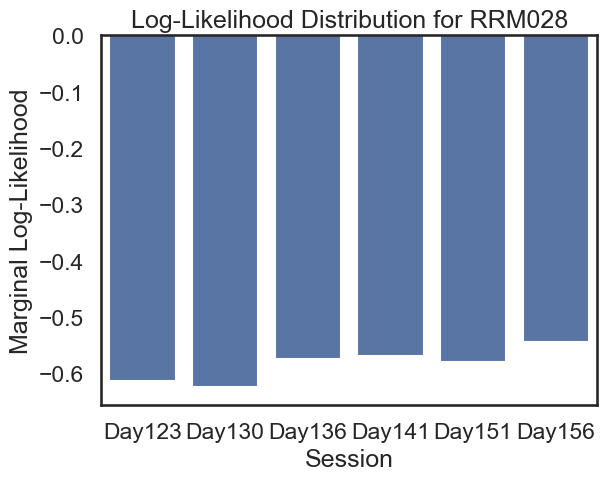

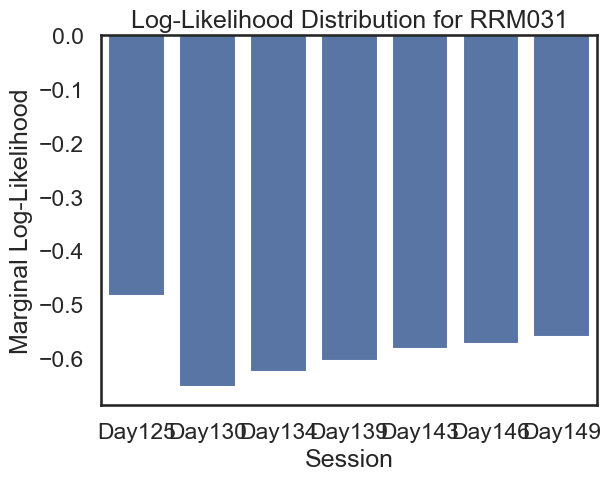

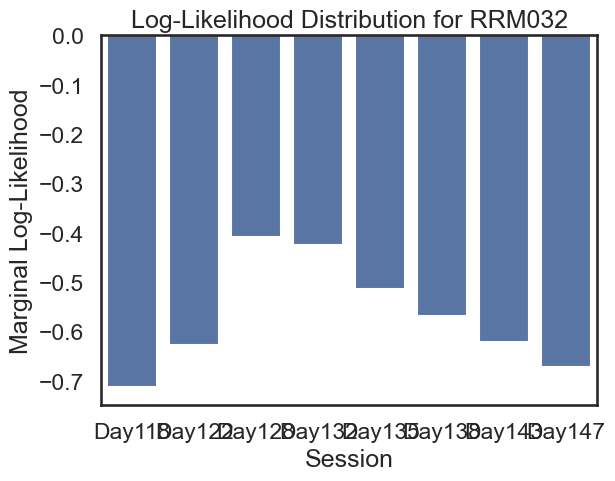

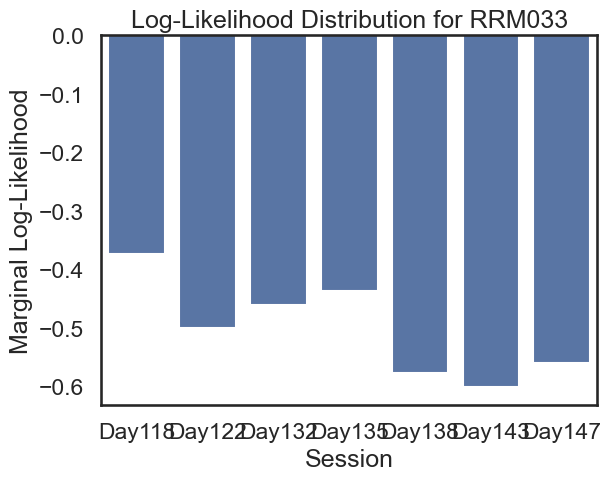

In [31]:
for animal_id in animals_to_model:
    # Filter results for the current animal
    animal_results = ll_results_df[ll_results_df['animal'] == animal_id].reset_index(drop=True)
    animal_results['likelihood'] = animal_results['likelihood'].astype(float)
    sns.barplot(data=animal_results, x='session', y='likelihood')    
    # plt.plot(animal_results['likelihood'])
    plt.title(f'Log-Likelihood Distribution for {animal_id}')
    plt.xlabel('Session')
    plt.ylabel('Marginal Log-Likelihood')
    plt.show()

In [71]:
ll_results_df

,animal,session,likelihood
0,RRM028,Day123,-174.17229
1,RRM028,Day130,-218.84416
2,RRM028,Day136,-230.58429
3,RRM028,Day141,-217.07822
4,RRM028,Day151,-121.354614
5,RRM028,Day156,-116.5225
6,RRM031,Day125,-113.00301
7,RRM031,Day130,-156.53087
8,RRM031,Day134,-227.70619
9,RRM031,Day139,-199.28108


In [59]:
# backup code modules
# logistic regression
'''
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_scaled, y)

initial_weights = lr.coef_
initial_biases = lr.intercept_
'''
# Elbow method to decide the number of states
'''
key = jr.PRNGKey(3)
k1, k2, k3 = jr.split(key, 3)
input_dim = X.shape[1]

animal = 'RRM028'
animal_of_interest = data_df[data_df['animal'] == animal]

marginal_lls = []
state_numbers = range(2, 20)

session_counts = animal_of_interest['session'].value_counts()
total_samples = len(animal_of_interest)
session_weights = {session: count / total_samples for session, count in session_counts.items()}
sessions = animal_of_interest['session'].unique()

for num_states in state_numbers:
    fold_test_lls = []
    for session in sessions:
        session_mask = (data_df['animal'] == animal) & (data_df['session'] == session)
        X_session, y_session = X_scaled[session_mask], y[session_mask]
        
        n_samples = len(X_session)
        train_end = int(0.8 * n_samples)
        X_train, y_train = X_session[:train_end], y_session[:train_end]
        X_test, y_test = X_session[train_end:], y_session[train_end:]

        sample_weight = session_weights[session]
        # weighted_y_train = y_train * sample_weight
        # weighted_X_train = X_train * sample_weight 

        hmm = LogisticRegressionHMM(num_states=num_states, input_dim=input_dim, transition_matrix_stickiness=5.0)
        weights = initial_weights + 0.01 * jr.normal(k2, shape=(num_states, input_dim))
        biases = initial_biases + 0.01 * jr.normal(k3, shape=(num_states,))
        params, props = hmm.initialize(key=k1, emission_weights=weights, emission_biases=biases)
        params, lps = hmm.fit_em(params, props, y_session, inputs=X_session, num_iters=100)

        marginal_ll_test = hmm.marginal_log_prob(params, y_session, inputs=X_session)
        fold_test_lls.append(marginal_ll_test)
    marginal_lls.append(np.mean(fold_test_lls))
    
plt.plot(state_numbers, marginal_lls, marker='o')
plt.xlabel('Number of Hidden States')
plt.ylabel('Marginal Log-Likelihood')
plt.title('Elbow Method for Optimal Number of Hidden States')
plt.show()
'''
# run the model in concatenated sessions from an animal
'''
num_states = 6
animals = behavior_df['animal'].unique()

fold_test_lls = []

for animal in animals:
    animal_mask = data_df['animal'] == animal
    X_animal, y_animal = X_scaled[animal_mask], y[animal_mask]

    sample_weight = session_weights[session]
    # weighted_y_train = y_train * sample_weight  
    # weighted_X_train = X_train * sample_weight 

    hmm = LogisticRegressionHMM(num_states=num_states, input_dim=input_dim, transition_matrix_stickiness=5.0)
    weights = initial_weights + 0.01 * jr.normal(k2, shape=(num_states, input_dim))
    biases = initial_biases + 0.01 * jr.normal(k3, shape=(num_states,))
    params, props = hmm.initialize(key=k1, emission_weights=weights, emission_biases=biases)
    params, lps = hmm.fit_em(params, props, y_animal, inputs=X_animal, num_iters=100)

    marginal_ll_test = hmm.marginal_log_prob(params, y_animal, inputs=X_animal)
    fold_test_lls.append(marginal_ll_test)

average_marginal_ll_test = np.mean(fold_test_lls)
print(f"Average Marginal Log-Likelihood on Test Set: {average_marginal_ll_test:.2f}")
plt.plot(fold_test_lls)
'''
# run the model in concatenated sessions from an animal
'''
num_states = 3
animals = behavior_df['animal'].unique()

animal_length = []

for animal in animals:
    animal_mask = data_df['animal'] == animal
    X_animal, y_animal = X_scaled[animal_mask], y[animal_mask]
    animal_length.append(len(X_animal))
average_marginal_ll_test = np.mean(fold_test_lls)
print(f"Average Marginal Log-Likelihood on Test Set: {average_marginal_ll_test:.2f}")
plt.plot(animal_length)
plt.gca().invert_yaxis()
'''
# time aware cross-validation, run the model in each session separately
'''
num_states = 3
session_counts = animal_of_interest['session'].value_counts()
total_samples = len(animal_of_interest)
session_weights = {session: count / total_samples for session, count in session_counts.items()}
sessions = animal_of_interest['session'].unique()

fold_test_lls = []

for session in sessions:
    session_mask = animal_of_interest['session'] == session
    X_session, y_session = X_scaled[session_mask], y[session_mask]
    
    n_samples = len(X_session)
    train_end = int(0.8 * n_samples)
    X_train, y_train = X_session[:train_end], y_session[:train_end]
    X_test, y_test = X_session[train_end:], y_session[train_end:]

    sample_weight = session_weights[session]
    # weighted_y_train = y_train * sample_weight  
    # weighted_X_train = X_train * sample_weight 

    hmm = LogisticRegressionHMM(num_states=num_states, input_dim=input_dim, transition_matrix_stickiness=5.0)
    weights = initial_weights + 0.01 * jr.normal(k2, shape=(num_states, input_dim))
    biases = initial_biases + 0.01 * jr.normal(k3, shape=(num_states,))
    params, props = hmm.initialize(key=k1, emission_weights=weights, emission_biases=biases)
    params, lps = hmm.fit_em(params, props, y_session, inputs=X_session, num_iters=100)

    marginal_ll_test = hmm.marginal_log_prob(params, y_session, inputs=X_session)
    fold_test_lls.append(marginal_ll_test)

average_marginal_ll_test = np.mean(fold_test_lls)
print(f"Average Marginal Log-Likelihood on Test Set: {average_marginal_ll_test:.2f}")
plt.plot(fold_test_lls)
'''
# run the model in concatenated sessions from an animal
'''
num_states = 3
animals = behavior_df['animal'].unique()

fold_test_lls = []

for animal in animals:
    animal_mask = behavior_df['animal'] == animal
    X_animal, y_animal = X_scaled[animal_mask], y[animal_mask]
    
    n_samples = len(X_animal)
    train_end = int(0.8 * n_samples)
    X_train, y_train = X_animal[:train_end], y_animal[:train_end]
    X_test, y_test = X_animal[train_end:], y_animal[train_end:]

    sample_weight = session_weights[session]
    # weighted_y_train = y_train * sample_weight  
    # weighted_X_train = X_train * sample_weight 

    hmm = LogisticRegressionHMM(num_states=num_states, input_dim=input_dim, transition_matrix_stickiness=5.0)
    weights = initial_weights + 0.01 * jr.normal(k2, shape=(num_states, input_dim))
    biases = initial_biases + 0.01 * jr.normal(k3, shape=(num_states,))
    params, props = hmm.initialize(key=k1, emission_weights=weights, emission_biases=biases)
    params, lps = hmm.fit_em(params, props, y_animal, inputs=X_animal, num_iters=100)

    marginal_ll_test = hmm.marginal_log_prob(params, y_animal, inputs=X_animal)
    fold_test_lls.append(marginal_ll_test)

average_marginal_ll_test = np.mean(fold_test_lls)
print(f"Average Marginal Log-Likelihood on Test Set: {average_marginal_ll_test:.2f}")
plt.plot(fold_test_lls)
'''
# plot convergence
# print("baseline:    ", lr.predict_log_proba(X_scaled)[np.arange(len(X_scaled)), y.astype(int)].sum())
# print("marginal LL: ", hmm.marginal_log_prob(params, y, inputs=X_scaled))
'''
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log joint probability")
'''

In [84]:
behavior_df['hidden_state'] = np.nan
behavior_df.loc[final_df.index, 'hidden_state'] = hmm.most_likely_states(params, y_final, inputs=X_final)

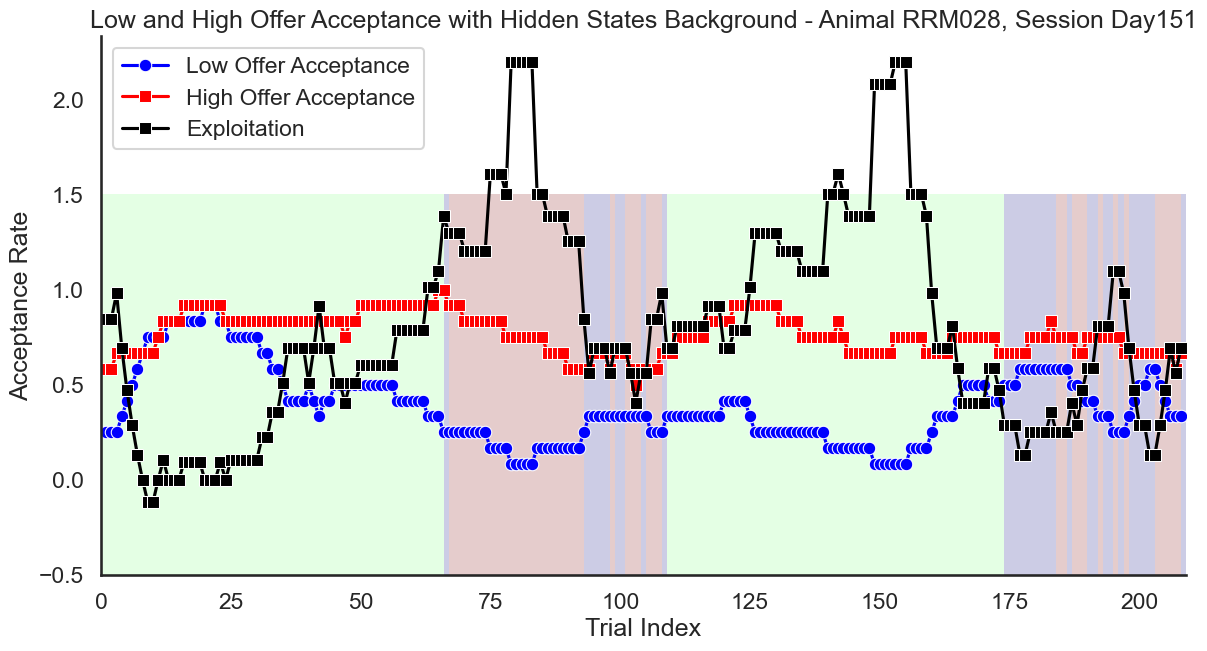

In [95]:
from matplotlib.colors import ListedColormap


# Define the animal ID and session ID you want to plot
animal_id = 'RRM028'
session_id = 'Day151'

plot_df = behavior_df[(behavior_df['animal'] == animal_id) & (behavior_df['session'] == session_id)]

# Extract the hidden states (z_star) for the background heatmap
z_star = plot_df['hidden_state'].values

# Create a colormap based on the unique hidden states
num_states = len(np.unique(z_star))
cmap = plt.get_cmap('jet', num_states)
colors = cmap(range(num_states))
custom_cmap = ListedColormap(colors)

# Create a new figure for the combined plot
plt.figure(figsize=(14, 7))

# Plot the hidden states as a background heatmap
plt.imshow(
    z_star[None, :], 
    aspect="auto", 
    interpolation="none", 
    extent=(0, len(z_star), -0.5, 1.5), 
    cmap=cmap, 
    alpha=0.2,  # Adjust transparency
)

# Overlay the line plots for low and high offer acceptance rates
sns.lineplot(
    data=plot_df,
    x=np.arange(len(plot_df)),
    y='low_accept_rate',
    markers=True,
    dashes=False,
    marker='o',
    color='blue',
    label='Low Offer Acceptance'
)

sns.lineplot(
    data=plot_df,
    x=np.arange(len(plot_df)),
    y='high_accept_rate',
    markers=True,
    dashes=False,
    marker='s',
    color='red',
    label='High Offer Acceptance'
)

sns.lineplot(
    data=plot_df,
    x=np.arange(len(plot_df)),
    y='exploitation',
    markers=True,
    dashes=False,
    marker='s',
    color='black',
    label='Exploitation'
)
sns.despine()

# Set labels and title
plt.xlabel('Trial Index')
plt.ylabel('Acceptance Rate')
plt.title(f'Low and High Offer Acceptance with Hidden States Background - Animal {animal_id}, Session {session_id}')

legend_handles = [
    plt.Line2D([0], [0], color=custom_cmap(i), lw=4, label=f'State {state}')
    for i, state in enumerate(np.unique(z_star))
]
plt.legend(handles=legend_handles, title='Hidden States', loc='upper right')

# Display the legend for line plots
plt.legend(loc='upper left')

# Show the plot
plt.show()


In [89]:
# logits = X @ params.emissions.weights + params.emissions.biases
logits = jnp.einsum('ti,ti->t', X_scaled, params.emissions.weights[z_star])
logits += params.emissions.biases[z_star]
plt.imshow(z_star[None, :], aspect="auto", interpolation="none", extent=(0, len(y), -5, 5), cmap='jet', alpha=0.25)
plt.plot(logits)
plt.plot(-1 + 2 * y, 'k.')
plt.axhline(0, linestyle=':', color='k')
plt.xlim(800, 1000)

TypeError: Indexer must have integer or boolean type, got indexer with type float32 at position 0, indexer value [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0.
 0. 0. 2. 0. 0. 2. 2. 2. 0. 2. 2. 2. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 0. 2. 2. 2. 0. 0.
 2. 0. 0. 2. 0. 2. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 0.]

/var/folders/81/kqx_5t9n5vz_mq7d7n66fmdr0000gn/T/ipykernel_63267/2885801623.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


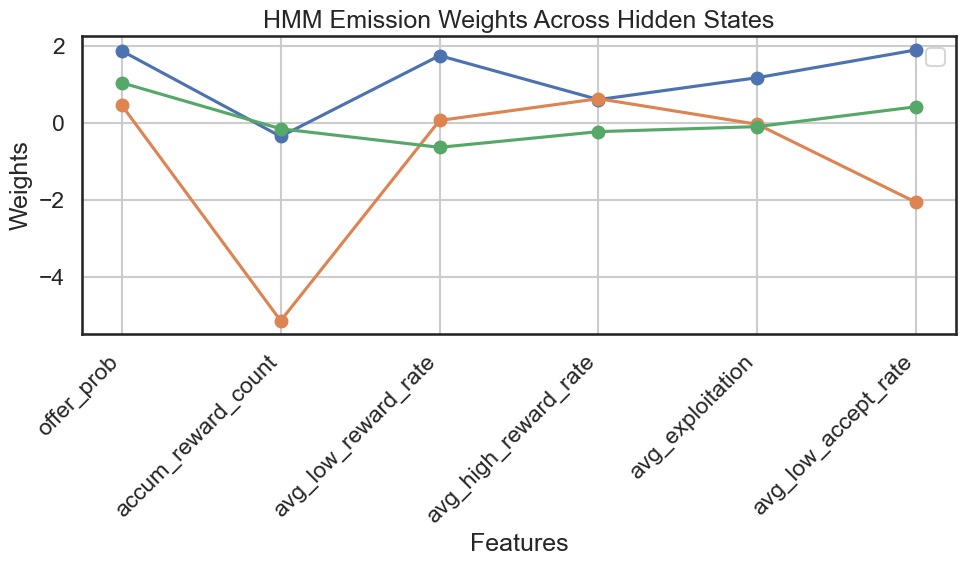

In [90]:
weights = params.emissions.weights.T

plt.figure(figsize=(10, 6))
plt.plot(weights, '-o')

plt.xticks(ticks=range(len(selected_columns)), labels=selected_columns, rotation=45, ha='right')

plt.xlabel('Features')
plt.ylabel('Weights')
plt.title('HMM Emission Weights Across Hidden States')

plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjusts the layout to prevent overlapping labels
plt.show()

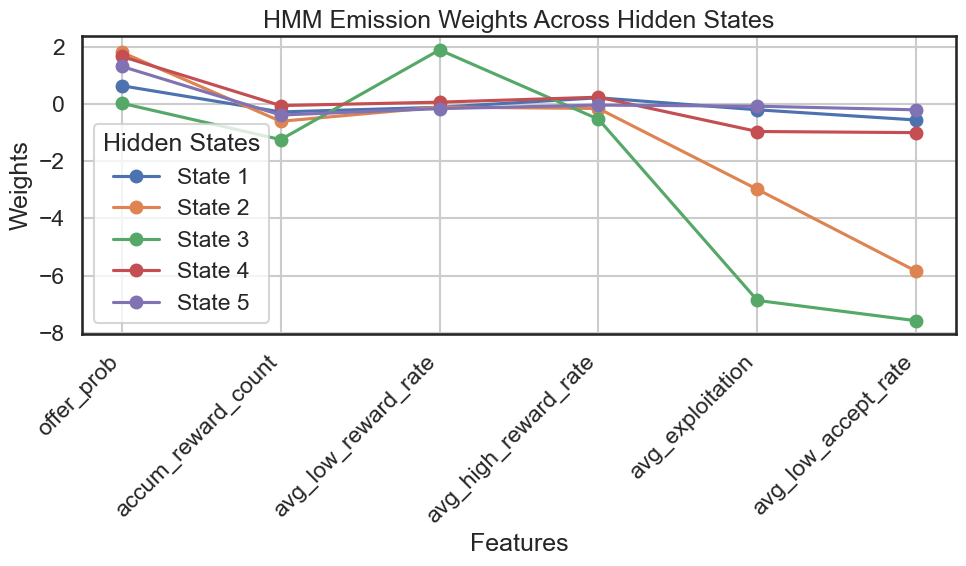

In [72]:
weights = params.emissions.weights.T
num_states = weights.shape[1]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with a label indicating the hidden state
for state in range(num_states):
    plt.plot(weights[:, state], '-o', label=f'State {state + 1}')

# Add feature names as x-ticks
plt.xticks(ticks=range(len(selected_columns)), labels=selected_columns, rotation=45, ha='right')

# Label axes and add title
plt.xlabel('Features')
plt.ylabel('Weights')
plt.title('HMM Emission Weights Across Hidden States')

# Show grid for better readability
plt.grid(True)

# Add a legend to show which line corresponds to which hidden state
plt.legend(title='Hidden States')

# Display the plot
plt.tight_layout()  # Adjusts the layout to prevent overlapping labels
plt.show()